In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.stats import norm, uniform

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
mpl.rcParams["figure.figsize"] = (15,8)
plt.style.use("bmh")

In [3]:
def round_to(x, rounding_val):
    return np.round(x / rounding_val) * rounding_val

In [4]:
def generate_norm_samples_with_bins(sample_size, mu, sigma, bin_size):
    normal = norm(loc=mu, scale=sigma)
    sample = pd.DataFrame(normal.rvs(sample_size), columns=['x'])
    sample['bin_j'] = sample['x'].apply(lambda x: int(np.floor((x/bin_size))))
    return sample

def get_bin_counts(sample):
    bin_counts = pd.DataFrame(sample['bin_j'].value_counts()).sort_index()
    return bin_counts

In [5]:
def normal_mle(sample):
    """
    Returns (mu, sigma) MLE for Normal Distribution Sample
    """
    mu = sample['x'].mean()
    sigma_sq = ((sample['x'] - mu)**2).mean()
    return (mu, np.sqrt(sigma_sq))

def normal_log_likeli(mu, sigma, sample):
    n = len(sample)
    
    return (
        -n * np.log(2*np.pi) / 2
        -n * np.log(sigma ** 2) / 2
        -(sample['x'] - mu).apply(np.square).sum() / (2 * sigma**2)
    )

def normal_mu_fisher_info(sigma, n=1):
    return n/sigma**2

def normal_sigma_fisher_info(sigma, n=1):
    return 2*n/sigma**2

In [6]:
def cdf_diff_inner(mu, sigma, j, bin_size):
    if np.sign((j + 1) * bin_size - mu) != np.sign(j*bin_size - mu):
        start = (j * bin_size - mu) / sigma
        end = ((j + 1) * bin_size - mu) / sigma
    else:
        start = -np.abs((j + 1) * bin_size - mu) / sigma
        end = -np.abs(j * bin_size - mu) / sigma
    return np.abs(norm.cdf(end) - norm.cdf(start))

cdf_diff_inner = np.vectorize(cdf_diff_inner, excluded=[0, 1, 3])

def cdf_diff(mu, sigma, bjs, bin_size):
    """
    Returns difference in Normal CDF evaluated between start and end of given bins.
    """
    return pd.Series(
        data=cdf_diff_inner(mu, sigma, bjs.index, bin_size),
        index=bjs.index
    )


def bin_log_likeli(mu, sigma, bjs, bin_size):
    """
    Returns binned-normal log-likelihood function of  for observations.
    """
    return np.sum(
        bjs['bin_j'] * (np.log(cdf_diff(mu, sigma, bjs, bin_size)))
    )


def bin_dmu2(mu, sigma, bjs, bin_size):
    """
    Returns second derivative of binned-normal log-likelihood function with respect to
    mu^2 for observations.
    """
    first_term = np.sum(
        bjs['bin_j'] * (
            (
                ((bjs.index + 1) * bin_size - mu) * norm.pdf(((bjs.index + 1) * bin_size - mu) / sigma)
                - (bjs.index * bin_size - mu) * norm.pdf((bjs.index * bin_size - mu) / sigma)
            ) / cdf_diff(mu, sigma, bjs, bin_size)
        )
    ) / (sigma**3)
    second_term = np.sum(
        bjs['bin_j'] * (
            (
                norm.pdf(((bjs.index + 1) * bin_size - mu) / sigma)
                - norm.pdf((bjs.index * bin_size - mu) / sigma)
            ) / cdf_diff(mu, sigma, bjs, bin_size)
        )**2
    ) / (sigma**2)
    
    return first_term - second_term


def bin_dsigma2(mu, sigma, bjs, bin_size):
    """
    Returns second derivative of binned-normal log-likelihood function with respect to
    sigma^2 for observations.
    """
    first_term = np.sum(
        bjs['bin_j'] * (
            (bjs.index * bin_size - mu) * ((bjs.index * bin_size - mu)**2 - 2*sigma**2)
            * norm.pdf((bjs.index * bin_size - mu) / sigma)
            / cdf_diff(mu, sigma, bjs, bin_size)
        )
    ) / (sigma**5)
    
    second_term = np.sum(
        bjs['bin_j'] * (
            ((bjs.index + 1) * bin_size - mu) * (((bjs.index + 1) * bin_size - mu)**2 - 2*sigma**2)
            * norm.pdf(((bjs.index + 1) * bin_size - mu) / sigma)
            / cdf_diff(mu, sigma, bjs, bin_size)
        )
    ) / (sigma**5)
    
    third_term = np.sum(
        bjs['bin_j'] * (
            (
                (bjs.index * bin_size - mu) * norm.pdf((bjs.index * bin_size - mu) / sigma)
                - ((bjs.index + 1) * bin_size - mu) * norm.pdf(((bjs.index + 1) * bin_size - mu) / sigma)
            ) / cdf_diff(mu, sigma, bjs, bin_size)
        )**2
    ) / (sigma**4)
    
    return first_term - second_term - third_term
    

def bin_dmu_dsigma(mu, sigma, bjs, bin_size):
    """
    Returns second derivative of binned-normal log-likelihood function with respect to
    mu and sigma for observations.
    """
    first_term = np.sum(
        bjs['bin_j'] * (
            ((bjs.index * bin_size - mu) ** 2 - sigma ** 2)
            * norm.pdf((bjs.index * bin_size - mu)/sigma)
            / cdf_diff(mu, sigma, bjs, bin_size)
        )
    ) / (sigma**4)
    
    second_term = np.sum(
        bjs['bin_j'] * (
            (((bjs.index + 1) * bin_size - mu) ** 2 - sigma ** 2)
            * norm.pdf(((bjs.index + 1) * bin_size - mu)/sigma)
            / cdf_diff(mu, sigma, bjs, bin_size)
        )
    ) / (sigma**4)
    
    third_term =np.sum(
        bjs['bin_j'] * (
            norm.pdf((bjs.index * bin_size - mu)/sigma) - norm.pdf(((bjs.index + 1) * bin_size - mu)/sigma)
            * (
                (bjs.index * bin_size - mu) * norm.pdf((bjs.index * bin_size - mu) / sigma)
                - ((bjs.index + 1) * bin_size - mu) * norm.pdf(((bjs.index + 1) * bin_size - mu) / sigma)
            )
            / cdf_diff(mu, sigma, bjs, bin_size)**2
        )
    ) / (sigma**3)

    return first_term - second_term - third_term

In [7]:
def get_js(mu, sigma, bin_size, n_devs=20):
    """
    Returns bin numbers for use in calculating Expected Fisher Information.
    Because the sum would be over infinitely many bins, we want to use a reasonable number of bins as
    the values quickly drop off anyway.
    
    Returns a pandas series with index equal to the js as well, this allows it to be 
    passed into cdf_diff which requires the js as index values.
    """
    middle_j = int(np.floor((mu/bin_size)))
    min_j = int(middle_j - n_devs * sigma / bin_size)
    max_j = int(middle_j + n_devs * sigma / bin_size)
    
    js = np.arange(min_j, max_j+1)
    
    return pd.Series(js, index=js)
    

def bin_mu_fisher_info(mu, sigma, bin_size, n=1, n_devs=20):
    """
    n is Number of observations
    n_devs is how many standard deviations away from the mean we wish to sum over.
    Currently, setting n_devs too large (>8) causes cdf_diff to round to 0, meaning np.inf is returned.
    """
    js = get_js(mu, sigma, bin_size, n_devs)
    first_term = np.sum(
        (
            ((js + 1) * bin_size - mu) * norm.pdf(((js + 1) * bin_size - mu) / sigma)
            - (js * bin_size - mu) * norm.pdf((js * bin_size - mu) / sigma)
        )
    ) / (sigma**3)
    second_term = np.sum(
        (
            norm.pdf(((js + 1) * bin_size - mu) / sigma)
            - norm.pdf((js * bin_size - mu) / sigma)
        )**2 / cdf_diff(mu, sigma, js, bin_size)
    ) / (sigma**2)
    
    return -n * (first_term - second_term)

In [8]:
def bin_mu_fisher_info_new(sigma, bin_size, n=1, n_devs=20):
    js = get_js(0, sigma, bin_size, n_devs)
    return n * np.sum(
        np.square(
            norm.pdf((js + 1) * bin_size / sigma)
            - norm.pdf(js * bin_size / sigma)
        ) / cdf_diff(0, sigma, js, bin_size)
    ) / (sigma**2)


def bin_mu_fisher_info_newnew(sigma, bin_size, n=1, n_devs=20):
    js = get_js(0, sigma, bin_size, n_devs)
    return n * np.sum(
        np.exp(
            np.log(np.square(
                norm.pdf((js + 1) * bin_size / sigma)
                - norm.pdf(js * bin_size / sigma)
            )) - np.log(cdf_diff(0, sigma, js, bin_size))
        )
    ) / (sigma**2)


def bin_mu_sigma_fisher_info(mu, sigma, bin_size, n=1, n_devs=20):
    js = get_js(mu, sigma, bin_size, n_devs)
    first_term = np.sum(
        (
            ((js * bin_size - mu) ** 2 - sigma ** 2)
            * norm.pdf((js * bin_size - mu)/sigma)
        )
    ) / (sigma**4)
    
    second_term = np.sum(
        (
            (((js + 1) * bin_size - mu) ** 2 - sigma ** 2)
            * norm.pdf(((js + 1) * bin_size - mu)/sigma)
        )
    ) / (sigma**4)
    
    third_term = np.sum(
        (
            norm.pdf((js * bin_size - mu)/sigma) - norm.pdf(((js + 1) * bin_size - mu)/sigma)
        )
        * (
            (js * bin_size - mu) * norm.pdf((js * bin_size - mu) / sigma)
            - ((js + 1) * bin_size - mu) * norm.pdf(((js + 1) * bin_size - mu) / sigma)
        )
        / cdf_diff(mu, sigma, js, bin_size)
    ) / (sigma**3)

    return -n * (first_term - second_term - third_term)

def bin_sigma_fisher_info(mu, sigma, bin_size, n=1, n_devs=20):
    js = get_js(mu, sigma, bin_size, n_devs)
    first_term = np.sum(
        (js * bin_size - mu) * ((js * bin_size - mu)**2 - 2*sigma**2)
        * norm.pdf((js * bin_size - mu) / sigma)
    ) / (sigma**5)
    
    second_term = np.sum(
        ((js + 1) * bin_size - mu) * (((js + 1) * bin_size - mu)**2 - 2*sigma**2)
        * norm.pdf(((js + 1) * bin_size - mu) / sigma)
    ) / (sigma**5)
    
    third_term = np.sum(
        (
            (js * bin_size - mu) * norm.pdf((js * bin_size - mu) / sigma)
            - ((js + 1) * bin_size - mu) * norm.pdf(((js + 1) * bin_size - mu) / sigma)
        )**2 / cdf_diff(mu, sigma, js, bin_size)
    ) / (sigma**4)
    
    return -n * (first_term - second_term - third_term)

In [40]:
sample_size = 1500
sigma = 1
mu = 0
bin_size = 3

sample = generate_norm_samples_with_bins(sample_size, mu, sigma, bin_size)
bjs = get_bin_counts(sample)

mu_hat, sigma_hat = normal_mle(sample)

Text(0.5, 0, 'x')

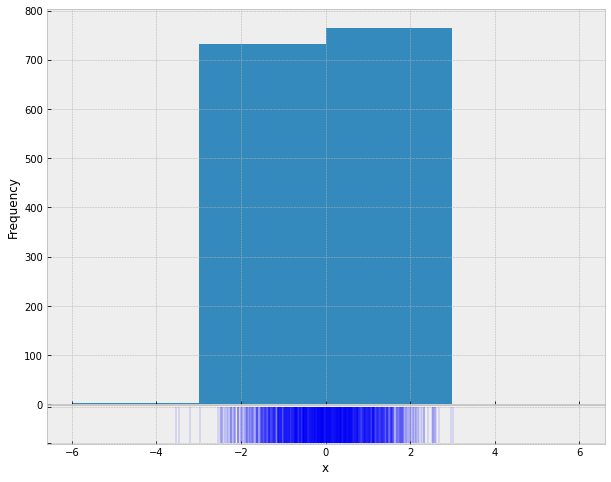

In [41]:
bins=[-6, -3, 0, 3, 6]

fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(2, 1, height_ratios=(10, 1), hspace=0.0025)

ax = fig.add_subplot(gs[0, 0])
ax_tick = fig.add_subplot(gs[1, 0], sharex=ax)

ax.hist(sample['x'], bins=bins)
ax.tick_params(axis="x", labelbottom=False)
ax.set_ylabel('Frequency')

ax_tick.vlines(sample['x'], 0, 1, color='b', alpha=0.1)
ax_tick.tick_params(axis="y", labelleft=False)
ax_tick.set_xlabel('x')

# ax.set_title(f'Plot of {sample_size} Continuous and {bin_size}-Binned Normal({mu}, {sigma}) Samples');

In [42]:
mus = np.linspace(-1, 1, num=75)
sigmas = np.linspace(0.7, 1.3, num=75)
MU, SIGMA = np.meshgrid(mus, sigmas)
params = list(product(mus, sigmas))
params_df = pd.DataFrame(params, columns=['mu', 'sigma'])

log_likelihoods = [
    normal_log_likeli(mu, sigma, sample) for mu, sigma in tqdm(params)
]
params_df['log_likeli'] = log_likelihoods

binned_log_likelihoods = [
    bin_log_likeli(mu, sigma, bjs, bin_size) for mu, sigma in tqdm(params)
]
binned_mu_hat, binned_sigma_hat = params[np.argmax(binned_log_likelihoods)]

params_df['binned_log_likeli'] = binned_log_likelihoods
smallest_non_inf = params_df.loc[params_df['binned_log_likeli'] != -np.inf, 'binned_log_likeli'].min()
params_df['binned_log_likeli'].replace(-np.inf, smallest_non_inf, inplace=True)

(array([  3., 732., 764.,   1.]),
 array([-6, -3,  0,  3,  6]),
 <a list of 4 Patch objects>)

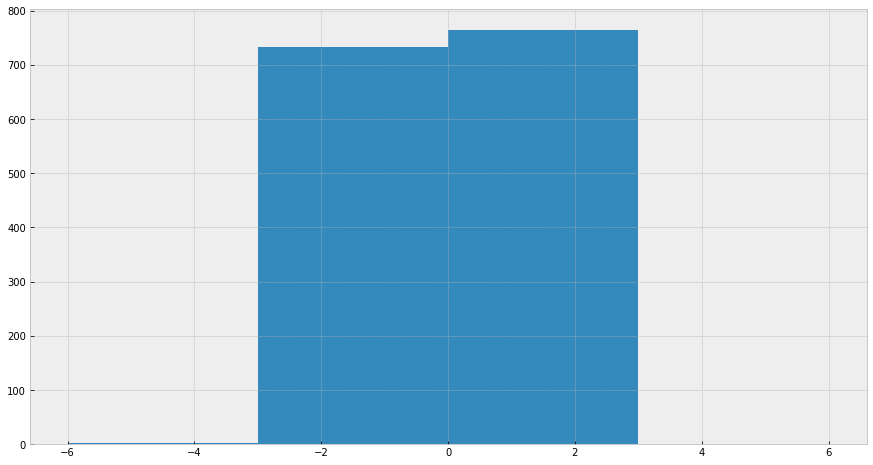

In [43]:
plt.hist(sample['x'], bins=[-6, -3, 0, 3, 6])

In [13]:
LOG_LIKELI = griddata(
    (params_df['mu'], params_df['sigma']), params_df['log_likeli'], (MU, SIGMA)
)

BINNED_LOG_LIKELI = griddata(
    (params_df['mu'], params_df['sigma']), params_df['binned_log_likeli'], (MU, SIGMA)
)

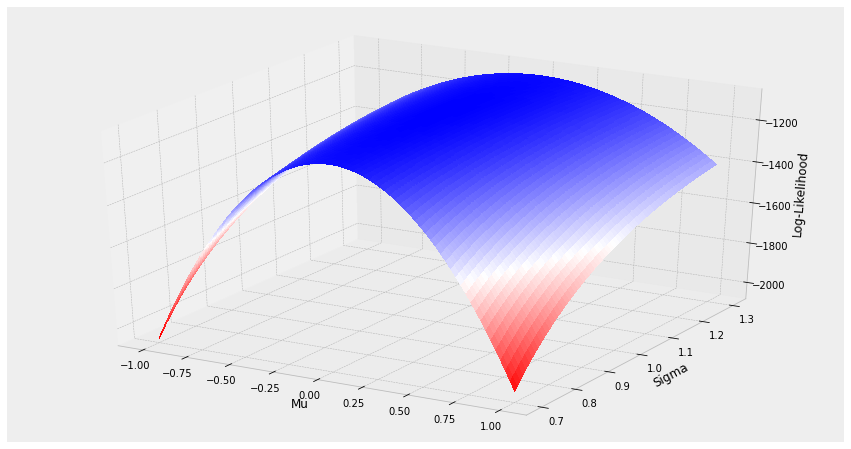

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(MU, SIGMA, BINNED_LOG_LIKELI, rstride=1, cstride=1, cmap=cm.bwr_r,
    linewidth=0, antialiased=False)

ax.set_zlabel('Log-Likelihood')

# plt.title('Binned Normal Log-Likelihood Surface')
plt.xlabel('Mu')
plt.ylabel('Sigma')
plt.show()

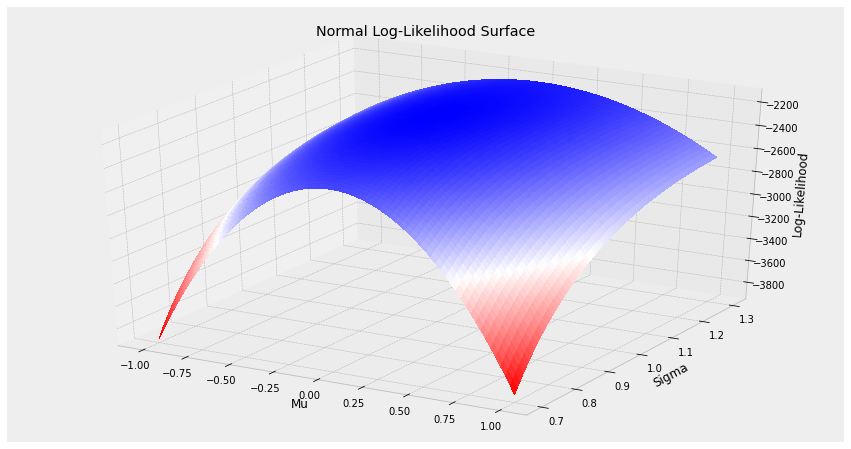

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(MU, SIGMA, LOG_LIKELI, rstride=1, cstride=1, cmap=cm.bwr_r,
    linewidth=0, antialiased=False)

ax.set_zlabel('Log-Likelihood')

plt.title('Normal Log-Likelihood Surface')
plt.xlabel('Mu')
plt.ylabel('Sigma')
plt.show()

In [16]:
print(f"Binned mu: {binned_mu_hat:.3f}, Binned sigma: {binned_sigma_hat:.3f}")
print(f"mu hat: {mu_hat:.3f}, sigma hat: {sigma_hat: .3f}")

Binned mu: 0.000, Binned sigma: 1.024
mu hat: 0.006, sigma hat:  0.998


In [17]:
bin_sizes = np.linspace(0.01, 59, num=300)

In [18]:
mu, sigma = (50, 1)

In [19]:
vectorised_sigma = np.vectorize(bin_sigma_fisher_info)
sigma_fisher_infos = vectorised_sigma(mu, sigma, bin_sizes, n_devs=60) / normal_sigma_fisher_info(sigma)

vectorised_mu = np.vectorize(bin_mu_fisher_info)
mu_fisher_infos = vectorised_mu(mu, sigma, bin_sizes, n=1, n_devs=60) / normal_mu_fisher_info(sigma)

Text(0.5, 1.0, 'Expected Fisher Information loss for μ=50, σ=1')

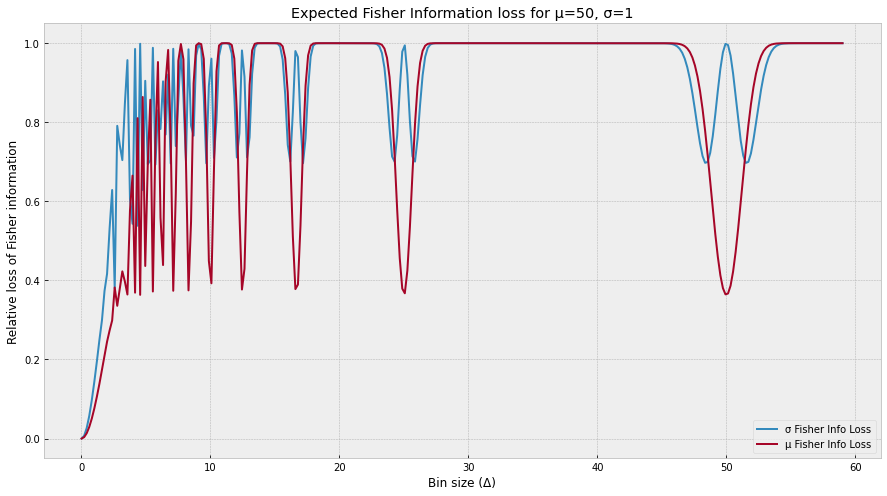

In [20]:
plt.plot(bin_sizes, 1 - sigma_fisher_infos, label='σ Fisher Info Loss')
plt.plot(bin_sizes, 1 - mu_fisher_infos, label='μ Fisher Info Loss')
plt.ylabel('Relative loss of Fisher information')
plt.xlabel('Bin size (Δ)')
plt.legend()
plt.title(f'Expected Fisher Information loss for μ={mu}, σ={sigma}')
# plt.savefig("mu50sig1.pdf")

In [21]:
bin_sizes[23]

4.547692307692308

In [22]:
(1 - mu_fisher_infos)[23]

0.3634351493372444

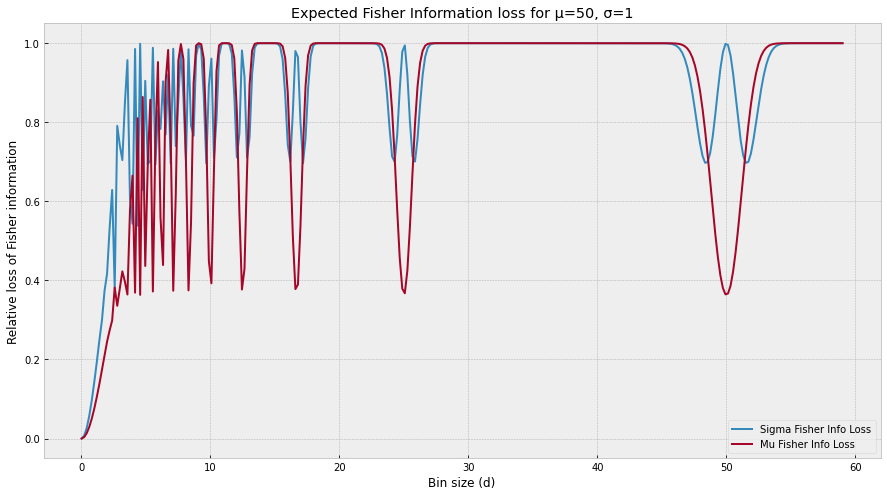

In [23]:
plt.plot(bin_sizes, 1 - sigma_fisher_infos, label='Sigma Fisher Info Loss')
plt.plot(bin_sizes, 1 - mu_fisher_infos, label='Mu Fisher Info Loss')
plt.ylabel('Relative loss of Fisher information')
plt.xlabel('Bin size (d)')
plt.legend()
plt.title(f'Expected Fisher Information loss for μ={mu}, σ={sigma}')
plt.show()

## Reconstruct from bins with uniform

In [24]:
def reconstruct_samples_from_bins(bjs, bin_size):
    reconstructed_samples = []
    for i, l in bjs.iterrows():
        n = l['bin_j']
        unif = uniform(loc=i*bin_size, scale=bin_size)
        reconstructed_samples.append(unif.rvs(n))
    reconstructed_samples = np.concatenate(reconstructed_samples, axis=0)
    return reconstructed_samples

def binned_log_likeli(bjs, bin_size, params):
    return bin_log_likeli(params[0], params[1], bjs, bin_size)

def get_binned_mle(bjs, bin_size, init_mu, init_sigma):
    mle = minimize(
        fun=lambda params: -binned_log_likeli(bjs, bin_size, params), x0=(init_mu, init_sigma)
    )
    return mle

In [25]:
def generate_errors(sample_size, mu, sigma, bin_size):
    sample = generate_norm_samples_with_bins(sample_size, mu, sigma, bin_size)
    bjs = get_bin_counts(sample)

    mu_hat, sigma_hat = normal_mle(sample)
    binned_mu_hat, binned_sigma_hat = get_binned_mle(bjs, bin_size, 0, 1).x

    reconstructed_samples = reconstruct_samples_from_bins(bjs, bin_size)
    recon_mu_hat, recon_sigma_hat = normal_mle(pd.DataFrame(reconstructed_samples, columns=['x']))

    errors = {
        'mu_hat_error': mu - mu_hat,
        'binned_mu_hat_error': mu - binned_mu_hat,
        'reconstructed_mu_hat_error': mu - recon_mu_hat,
        'sigma_hat_error': sigma - sigma_hat,
        'binned_sigma_hat_error': sigma - binned_sigma_hat,
        'reconstructed_sigma_hat_error': sigma - recon_sigma_hat,
    }

    return errors

def generate_n_errors(sample_size, mu, sigma, bin_size, n=1000):
    return pd.DataFrame([generate_errors(sample_size, mu=mu, sigma=sigma, bin_size=bin_size) for i in tqdm(range(1000))])

In [26]:
sample = generate_norm_samples_with_bins(sample_size, mu, sigma, bin_size)
bjs = get_bin_counts(sample)

mu_hat, sigma_hat = normal_mle(sample)
binned_mu_hat, binned_sigma_hat = get_binned_mle(bjs, bin_size, 0, 1).x

reconstructed_samples = reconstruct_samples_from_bins(bjs, bin_size)
recon_mu_hat, recon_sigma_hat = normal_mle(pd.DataFrame(reconstructed_samples, columns=['x']))

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [27]:
mu_hat, sigma_hat

(49.976505986684984, 1.012840680307437)

In [28]:
binned_mu_hat, binned_sigma_hat

(0.0, 1.0)

In [29]:
recon_mu_hat

49.898922044115594

In [30]:
sample_size = 300
sigma = 1
mu = 0
bin_size = 1

In [31]:
standard_normal = generate_n_errors(500, mu=0, sigma=1, bin_size=1, n=1000)
standard_normal_small_sample = generate_n_errors(50, mu=0, sigma=1, bin_size=1, n=1000)
standard_normal_2bin = generate_n_errors(500, mu=0, sigma=1, bin_size=2, n=1000)
normal_sd2 = generate_n_errors(500, mu=0, sigma=2, bin_size=1, n=1000)
normal_5bin = generate_n_errors(500, mu=0, sigma=1, bin_size=5, n=1000)
normal_offset_bin = generate_n_errors(500, mu=0.5, sigma=1, bin_size=1, n=1000)
normal_offset_2bin = generate_n_errors(500, mu=0.5, sigma=1, bin_size=2, n=1000)
normal_offset_tinybin = generate_n_errors(500, mu=0.5, sigma=1, bin_size=0.05, n=1000)

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: Runtime

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

KeyboardInterrupt: 

In [ ]:
print(f"Mu, Sigma MLE = ({mu_hat:.3f}, {sigma_hat:.3f}), Binned Mu, Sigma MLE = ({binned_mu_hat:.3f} {binned_sigma_hat:.3f}), Reconstructed Mu, Sigma = ({recon_mu_hat:.3f}, {recon_sigma_hat:.3f})")

In [ ]:
sample['x'].plot.kde(label=f'KDE of N({mu}, {sigma**2})sample')
pd.DataFrame(reconstructed_samples)[0].plot.kde(label=f'KDE of reconstructed sample from size {bin_size} bin counts')
plt.legend()

In [10]:
def bin_log_likeli2(bjs, bin_size, sigma, mu):
    """
    Returns binned-normal log-likelihood function of  for observations.
    """
    return np.sum(
        bjs['bin_j'] * (np.log(cdf_diff(mu, sigma, bjs, bin_size)))
    )

In [77]:
mles = []
binned_mles = []
init_mu = 0
sigma = 1
mu = 1
bin_size = 3
n=500

for i in tqdm(range(5000)):
    sample = generate_norm_samples_with_bins(n, mu, sigma, bin_size)
    bjs = get_bin_counts(sample)
    
    mle = sample['x'].mean()
    binned_mle = minimize(
        fun=lambda *mu: -bin_log_likeli2(bjs, bin_size, sigma, *mu), x0=(init_mu)
    ).x
    mles.append(mle)
    binned_mles.append(binned_mle)
    
    
    

mu_info = normal_mu_fisher_info(sigma, n)  
binned_mu_info = bin_mu_fisher_info(mu, sigma, bin_size, n)

mles = pd.DataFrame(mles)
binned_mles = pd.DataFrame(binned_mles)

In [78]:
mles[0].mean()

1.001163317818613

In [79]:
mles[0].std() ** 2

0.001960095761832412

In [80]:
1/mu_info

0.002

In [81]:
binned_mles[0].mean()

1.0023955845556989

In [82]:
binned_mles[0].std() ** 2

0.0036448582380803896

In [83]:
1 / binned_mu_info

0.0036997935123613233

In [84]:
vals = np.linspace(0.8, 1.2, 800)
pdf = norm.pdf(vals, loc=1,scale=1/np.sqrt(binned_mu_info))

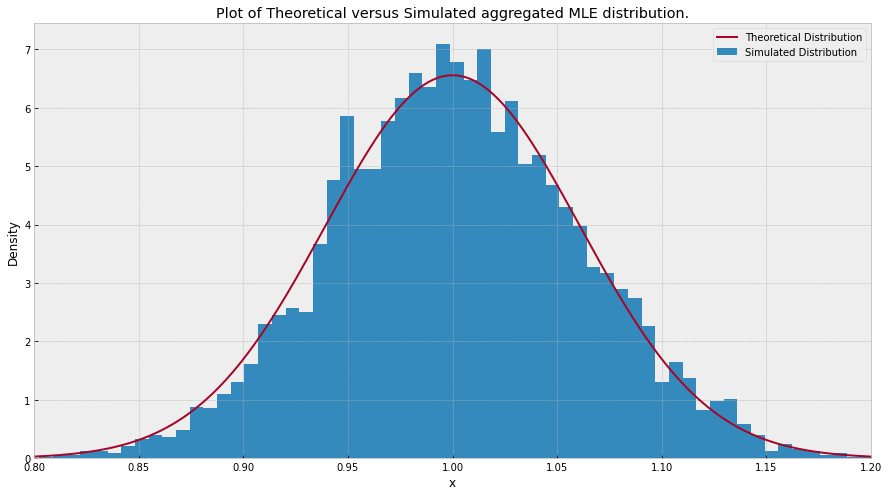

In [89]:
plt.hist(binned_mles[0], density=True, bins=80, label='Simulated Distribution');
plt.plot(vals, pdf, label='Theoretical Distribution')
plt.title("Plot of Theoretical versus Simulated aggregated MLE distribution.")
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(0.8, 1.2)
plt.savefig("./viva/mle_distribution.pdf")

# 2D

In [ ]:
from scipy.stats import multivariate_normal
import seaborn as sns

In [ ]:
rvs = pd.DataFrame(multivariate_normal(mean=(0, 0)).rvs(1000))

In [ ]:
plt.set_cmap('Greys')

fig, ax = plt.subplots()
ax.scatter(rvs[0], rvs[1], c='b', alpha=0.5)

ax.hist2d(rvs[0], rvs[1], bins=[x for x in range(-3, 4)], zorder=-1);
plt.title('2D-Histogram Plot of 1000 0-mean identity-variance bivariate Normal random variables.')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
# plt.savefig("2d_pixel.pdf", transparent=True)